In [256]:
import sys
sys.path.append('../')
from lib import mesh_sampling
import numpy as np
import json
import os
import copy
from facemesh import FaceData
import time
import pickle
import trimesh

try:
    import psbody.mesh
    found = True
except ImportError:
    found = False
if found:
    from psbody.mesh import Mesh, MeshViewer, MeshViewers

from autoencoder_dataset import autoencoder_dataset
from torch.utils.data import DataLoader

from spiral_utils import get_adj_trigs, generate_spirals
from models import SpiralAutoencoder, SpiralAutoencoder_extra_conv

from test_funcs import test_autoencoder_dataloader


import torch
from tensorboardX import SummaryWriter

from sklearn.metrics.pairwise import euclidean_distances
meshpackage = 'trimesh'
root_dir = '/data/gb318/datasets/'

name = ''
dataset = 'DFAUST'    

GPU = True
device_idx = 9
torch.cuda.get_device_name(device_idx)

'GeForce RTX 2080 Ti'

In [257]:
args = {}

generative_model = 'autoencoder'
dilation_flag = False
hardcode_down_ref = False
downsample_method = 'COMA_downsample' # choose'COMA_downsample' or 'meshlab_downsample'
downsample_config = ''

if dataset == 'COMA':
    reference_mesh_file = os.path.join(root_dir, dataset,'preprocessed/templates/template.obj')
    downsample_directory = os.path.join(root_dir, dataset,'preprocessed/templates',downsample_method,downsample_config)
elif dataset == 'DFAUST':
    reference_mesh_file = os.path.join(root_dir, dataset,'template/template.obj')
    downsample_directory = os.path.join(root_dir, dataset,'template',downsample_method,downsample_config)
    
ds_factors = [4, 4, 4, 4]
step_sizes = [1, 1, 1, 1, 1]
filter_sizes_enc = [[3, 16, 16, 16, 32],[[],[],[],[],[]]]
filter_sizes_dec = [[32, 32, 16, 16, 3],[[],[],[],[],[]]]
if dilation_flag:
    dilation=[2, 2, 2, 1, 1] 
else:
    dilation = None

args = {'generative_model': generative_model,
        'name': name, 'data': os.path.join(root_dir, dataset, 'preprocessed',name),
        'results_folder':  os.path.join(root_dir, dataset,'results/higher_order_'+ generative_model,
                                        downsample_method, downsample_config, 'TPAMI',
                                        '2nd_order_full_norm_final'),
        'reference_mesh_file':reference_mesh_file, 'downsample_directory': downsample_directory,
        'checkpoint_file': 'checkpoint',
        'seed':2, 
        'filter_sizes_enc': filter_sizes_enc, 'filter_sizes_dec': filter_sizes_dec,
        'nz':16,
        'ds_factors': ds_factors, 'step_sizes' : step_sizes, 'dilation': dilation,
        'injection': True, 'residual': False, 'order': 2, 
        'normalize': 'final', 'model': 'full', 'activation': 'elu',
        'nVal': 100, 'normalization': True,
        'mm_constant': 1000}

if generative_model == 'autoencoder':
    args['results_folder'] = os.path.join(args['results_folder'],\
                                          'latent_'+str(args['nz']))
    
if not os.path.exists(os.path.join(args['results_folder'])):
    os.makedirs(os.path.join(args['results_folder']))

summary_path = os.path.join(args['results_folder'],'summaries',args['name'])
if not os.path.exists(summary_path):
    os.makedirs(summary_path)  
    
checkpoint_path = os.path.join(args['results_folder'],'checkpoints', args['name'])
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
    
samples_path = os.path.join(args['results_folder'],'samples', args['name'])
if not os.path.exists(samples_path):
    os.makedirs(samples_path)
    
prediction_path = os.path.join(args['results_folder'],'predictions', args['name'])
if not os.path.exists(prediction_path):
    os.makedirs(prediction_path)

if not os.path.exists(downsample_directory):
    os.makedirs(downsample_directory)


if hardcode_down_ref:
    if dataset == 'COMA' and downsample_method == 'COMA_downsample':
        reference_points = [[3567,4051,4597],
                            [1010,1081,1170],
                            [256, 276, 295],
                            [11, 69, 74],
                            [17, 17, 17]]
    elif dataset == 'COMA' and downsample_method == 'meshlab_downsample' and\
            downsample_config == 'preserve_topology=True_preserve_boundary=False':
        reference_points = [[3567, 4051, 4597],
                             [1105, 1214, 1241],
                             [289, 310, 318],
                             [70, 80, 85],
                             [2, 19, 24]]
    else:
        raise NotImplementedError
else:
    if dataset == 'COMA':
        reference_points = [[3567,4051,4597]] 
    elif dataset == 'mein3d' or dataset == 'mein3d_texture':
        reference_points = [[23822]] 
    elif dataset == 'DFAUST':
        reference_points = [[414]]
        

In [258]:
np.random.seed(args['seed'])
print("Loading data .. ")
if not os.path.exists(args['data']+'/mean.npy') or not os.path.exists(args['data']+'/std.npy'):
    facedata = FaceData(nVal=args['nVal'], train_file=args['data']+'/train.npy',
                             test_file=args['data']+'/test.npy', reference_mesh_file=args['reference_mesh_file'],
                             pca_n_comp=args['nz'], normalization = args['normalization'],\
                             meshpackage = meshpackage, load_flag = True)
    np.save(args['data']+'/mean.npy', facedata.mean)
    np.save(args['data']+'/std.npy', facedata.std)
else:
    facedata = FaceData(nVal=args['nVal'], train_file=args['data']+'/train.npy',\
                        test_file=args['data']+'/test.npy', reference_mesh_file=args['reference_mesh_file'],\
                        pca_n_comp=args['nz'], normalization = args['normalization'],\
                        meshpackage = meshpackage, load_flag = False)
    facedata.mean = np.load(args['data']+'/mean.npy')
    facedata.std = np.load(args['data']+'/std.npy')
    facedata.n_vertex = facedata.mean.shape[0]
    facedata.n_features = facedata.mean.shape[1]

if not os.path.exists(os.path.join(args['downsample_directory'],'downsampling_matrices.pkl')):
    if facedata.meshpackage == 'trimesh':
        raise NotImplementedError
    print("Generating Transform Matrices ..")


    if downsample_method == 'COMA_downsample':
        M,A,D,U,F = mesh_sampling.generate_transform_matrices(facedata.reference_mesh, args['ds_factors'])
    elif downsample_method == 'meshlab_downsample':
        M,A,D,U,F = mesh_sampling.generate_transform_matrices_given_downsamples(facedata.reference_mesh,                                                                                args['downsample_directory'],                                                                                len(args['ds_factors']))
    else:
        raise NotImplementedError(downsample_method)
        
    with open(os.path.join(args['downsample_directory'],'downsampling_matrices.pkl'), 'wb') as fp:
        M_verts_faces = [(M[i].v, M[i].f) for i in range(len(M))]
        pickle.dump({'M_verts_faces':M_verts_faces,'A':A,'D':D,'U':U,'F':F}, fp)
else:
    print("Loading Transform Matrices ..")
    with open(os.path.join(args['downsample_directory'],'downsampling_matrices.pkl'), 'rb') as fp:
        downsampling_matrices = pickle.load(fp,encoding = 'latin1')
            
    M_verts_faces = downsampling_matrices['M_verts_faces']
    if facedata.meshpackage == 'mpi-mesh':
        M = [Mesh(v=M_verts_faces[i][0], f=M_verts_faces[i][1]) for i in range(len(M_verts_faces))]
    elif facedata.meshpackage == 'trimesh':
        M = [trimesh.base.Trimesh(vertices=M_verts_faces[i][0], faces=M_verts_faces[i][1], process = False)             for i in range(len(M_verts_faces))]
    A = downsampling_matrices['A']
    D = downsampling_matrices['D']
    U = downsampling_matrices['U']
    F = downsampling_matrices['F']
        

if not hardcode_down_ref:
    print("Calculating reference points for downsampled versions..")
    for i in range(len(args['ds_factors'])):
        if facedata.meshpackage == 'mpi-mesh':
            dist = euclidean_distances(M[i+1].v, M[0].v[reference_points[0]])
        elif facedata.meshpackage == 'trimesh':
            dist = euclidean_distances(M[i+1].vertices, M[0].vertices[reference_points[0]])
        reference_points.append(np.argmin(dist,axis=0).tolist())

if facedata.meshpackage == 'mpi-mesh':
    sizes = [x.v.shape[0] for x in M]
elif facedata.meshpackage == 'trimesh':
    sizes = [x.vertices.shape[0] for x in M]
Adj, Trigs = get_adj_trigs(A, F, facedata.reference_mesh, meshpackage = facedata.meshpackage)

spirals_np, spiral_sizes,spirals = generate_spirals(args['step_sizes'], M, Adj, Trigs, \
                                                    reference_points = reference_points, \
                                                    dilation = args['dilation'], random = False, \
                                                    meshpackage = facedata.meshpackage, counter_clockwise = True)

bU = []
bD = []
for i in range(len(D)):
    d = np.zeros((1,D[i].shape[0]+1,D[i].shape[1]+1))
    u = np.zeros((1,U[i].shape[0]+1,U[i].shape[1]+1))
    d[0,:-1,:-1] = D[i].todense()
    u[0,:-1,:-1] = U[i].todense()
    d[0,-1,-1] = 1
    u[0,-1,-1] = 1
    bD.append(d)
    bU.append(u)
    
# pytorch stuff

torch.manual_seed(args['seed'])

if GPU:
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

tspirals = [torch.from_numpy(s).long().to(device) for s in spirals_np]
tD = [torch.from_numpy(s).float().to(device) for s in bD]
tU = [torch.from_numpy(s).float().to(device) for s in bU]

dataset_test = autoencoder_dataset(root_dir = args['data'], points_dataset = 'test',
                                          facedata = facedata,
                                          normalization = args['normalization'])



Loading data .. 
Loading Transform Matrices ..
Calculating reference points for downsampled versions..
spiral generation for hierarchy 0 (6890 vertices) finished
spiral generation for hierarchy 1 (1723 vertices) finished
spiral generation for hierarchy 2 (431 vertices) finished
spiral generation for hierarchy 3 (108 vertices) finished
spiral generation for hierarchy 4 (27 vertices) finished
spiral sizes for hierarchy 0:  8
spiral sizes for hierarchy 1:  9
spiral sizes for hierarchy 2:  9
spiral sizes for hierarchy 3:  9
spiral sizes for hierarchy 4:  10
cuda:9


In [264]:
# shape_index = 1000
# shape_index = 1169
# shape_index = 2345
# shape_index = 4500
# shape_index = 3500
# shape_index = 1900
# shape_index = 3218 

shapedata_mean = torch.Tensor(facedata.mean).to(device)
shapedata_std = torch.Tensor(facedata.std).to(device)
template = trimesh.load(args['reference_mesh_file'], process = False)

x_recons = []
error_norms = []
index = []
base_results_folder = os.path.join(root_dir, dataset,'results', 
                                        'higher_order_{}'.format(generative_model),
                                        downsample_method, downsample_config, 'TPAMI')
argument_list = [['1st_order', False, False, 2, 'linear', None],
                 ['2nd_order_full_norm_final', True, False, 2, 'full', 'final'],
                 ['3rd_order_full_norm_2nd', True, False, 3, 'full', '2nd'],
                 ['4th_order_full_norm_2nd', True, False, 4, 'full', '2nd']]

for shape_index in [4500]:
    
    x = dataset_test[shape_index]['points'].to(device).unsqueeze(0)
    if dataset_test.dummy_node:
        x_unnorm = x[:,:-1]
    x_unnorm = ((x_unnorm * shapedata_std + shapedata_mean) * args['mm_constant']).squeeze()
    template.vertices = x_unnorm.cpu().numpy()
    trimesh.exchange.export.export_mesh(template, 
                                        os.path.join(base_results_folder, 'errors', 
                                                     'gt_shape_{}_errors.obj'.format(shape_index)));
    for i, arguments in enumerate(argument_list):

        args.update({'results_folder': os.path.join(base_results_folder, arguments[0], 'latent_{}'.format(args['nz'])),
                     'injection': arguments[1], 'residual': arguments[2], 
                     'order': arguments[3], 'model': arguments[4], 'normalize': arguments[5]})
        checkpoint_path = os.path.join(args['results_folder'],'checkpoints', args['name'])
        checkpoint_full_path = os.path.join(checkpoint_path, '{}.pth.tar'.format(args['checkpoint_file']))

        model = SpiralAutoencoder_extra_conv(filters_enc = args['filter_sizes_enc'],   
                                             filters_dec = args['filter_sizes_dec'],
                                             latent_size=args['nz'],
                                             sizes=sizes,
                                             spiral_sizes=spiral_sizes,
                                             spirals=tspirals,
                                             D=tD, U=tU,device=device,
                                             injection = args['injection'],
                                             residual = args['residual'],
                                             order = args['order'],
                                             normalize = args['normalize'],
                                             model = args['model'],
                                             activation = args['activation']).to(device).eval()


        print('loading checkpoint from file {}'.format(checkpoint_full_path))
        checkpoint_dict = torch.load(checkpoint_full_path,map_location=device)
        model.load_state_dict(checkpoint_dict['autoencoder_state_dict'])

        with torch.no_grad():
            x_recon = model(x)  
            if dataset_test.dummy_node:
                x_recon = x_recon[:,:-1]
            x_recon = ((x_recon * shapedata_std + shapedata_mean) * args['mm_constant']).squeeze()
            x_recons.append(x_recon)
            error_norms.append(torch.sqrt(torch.sum((x_recon - x_unnorm)**2,axis=1)))
            index.append(shape_index)


error_all = torch.cat((error_norms),0)
clr = trimesh.visual.color.interpolate(error_all.cpu().numpy(),color_map='inferno_r')
n = 0
for i, x_recon in enumerate(x_recons):
    template.vertices = x_recon.cpu().numpy()
    template.visual = trimesh.visual.create_visual(vertex_colors = clr[n:n+x_recon.shape[0],:])
    trimesh.exchange.export.export_mesh(template, 
                                        os.path.join(base_results_folder, 'errors', 
                                                     '{}_shape_{}_errors.obj'.format(argument_list[i%len(argument_list)][0], index[i])));
    n += x_recon.shape[0]


loading checkpoint from file /data/gb318/datasets/DFAUST/results/higher_order_autoencoder/COMA_downsample/TPAMI/1st_order/latent_16/checkpoints/checkpoint.pth.tar
loading checkpoint from file /data/gb318/datasets/DFAUST/results/higher_order_autoencoder/COMA_downsample/TPAMI/2nd_order_full_norm_final/latent_16/checkpoints/checkpoint.pth.tar
loading checkpoint from file /data/gb318/datasets/DFAUST/results/higher_order_autoencoder/COMA_downsample/TPAMI/3rd_order_full_norm_2nd/latent_16/checkpoints/checkpoint.pth.tar
loading checkpoint from file /data/gb318/datasets/DFAUST/results/higher_order_autoencoder/COMA_downsample/TPAMI/4th_order_full_norm_2nd/latent_16/checkpoints/checkpoint.pth.tar


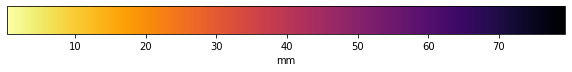

In [265]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.inferno_r
norm = mpl.colors.Normalize(vmin=error_all.min(), vmax=error_all.max())

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='mm')
plt.savefig(os.path.join(base_results_folder, 'errors', 'colorbar.png'), bbox_inches='tight')